<a href="https://colab.research.google.com/github/NehaKumari500092077/SAR-Data/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch.nn as nn

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [ ]:
num_rand_seeds = 20
test_size = 0.2
batch_size = 32
learning_rate = 0.001
num_epochs  = 150

In [ ]:
import pandas as pd
import numpy as np
file_path = r'/content/Drive/My Drive/ml/sar_complex_data1.xlsx'
excel_data = pd.read_excel(file_path, sheet_name=None)
print("Sheet Names:", excel_data.keys())
data = excel_data['Sheet1']

def change_column_names(data):
    data['s_moisture'] = data['MV (cm3/cm3)']
    data['s_roughness'] = data['rms (cm)']
    data.drop(columns=['MV (cm3/cm3)', 'rms (cm)'], axis=1, inplace=True)
    return data
data = change_column_names(data)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Drive/My Drive/ml/sar_complex_data1.xlsx'

In [ ]:
from IPython.display import display

display(data.describe().round(4))
data.describe().round(4).to_csv('/content/summary_stats.csv')
from google.colab import files
files.download('/content/summary_stats.csv')

,sl,Real_VV,Imag_VV,Real_VH,Imag_VH,s_moisture,s_roughness
count,638.000,638.0000,638.0000,638.0000,638.0000,638.0000,638.0000
mean,319.500,-0.0090,-0.0103,0.0019,-0.0019,0.1212,0.7752
std,184.319,0.2006,0.2066,0.1033,0.1095,0.1033,0.5558
min,1.000,-0.6273,-0.6238,-0.5080,-0.4996,0.0058,0.2100
25%,160.250,-0.1399,-0.1329,-0.0512,-0.0625,0.0364,0.2100
50%,319.500,-0.0136,-0.0035,0.0068,0.0000,0.0831,0.5700
75%,478.750,0.1286,0.1112,0.0629,0.0559,0.1930,1.0100
max,638.000,0.6951,0.6851,0.3578,0.3992,0.4789,2.0800


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
def set_seed(seed):
    # Fix random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Ensure deterministic behavior in cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Enforce deterministic algorithms for all ops
    torch.use_deterministic_algorithms(True)

    # Required for deterministic behavior in CUDA
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# set_seed(seed_value)

In [ ]:
X = data[['Real_VV','Imag_VV','Real_VH','Imag_VH']].values
y = data[['s_roughness','s_moisture']].values

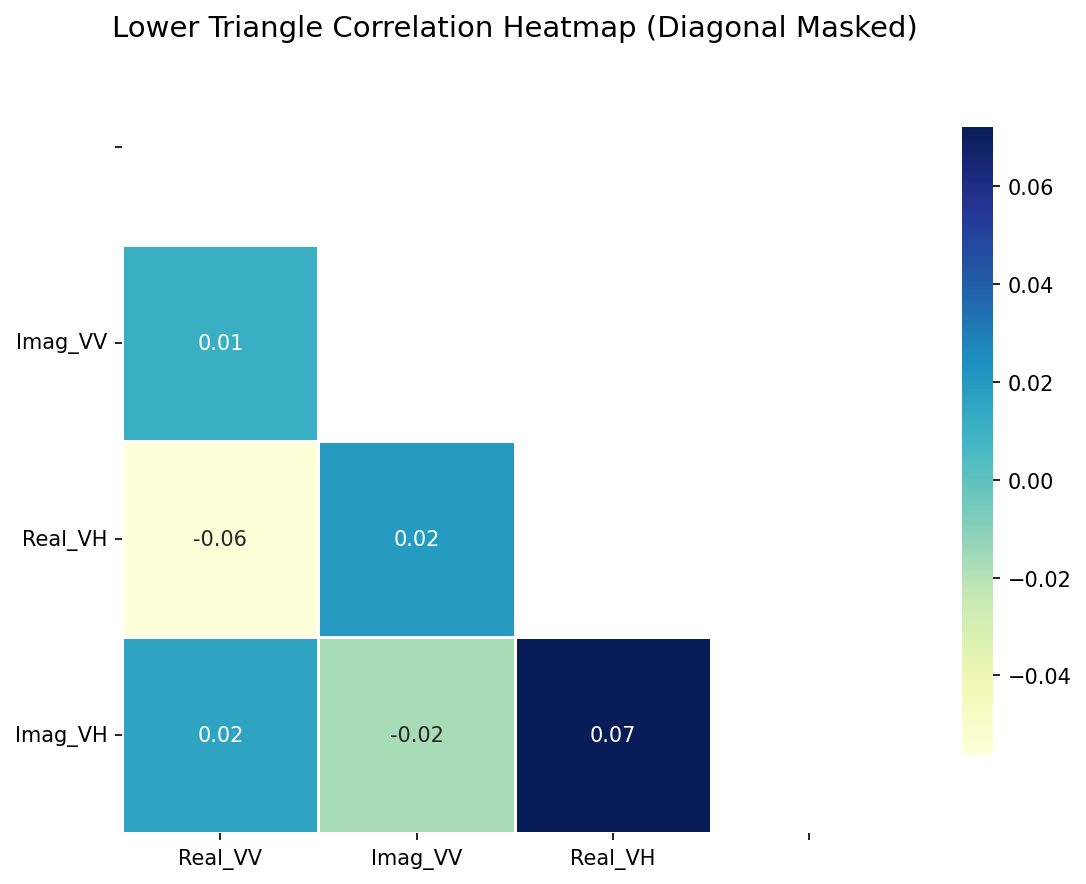

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Correlation and mask setup
selected_cols = ['Real_VV', 'Imag_VV', 'Real_VH', 'Imag_VH']
corr = data[selected_cols].corr()
mask = np.triu(np.ones(corr.shape), k=0).astype(bool)

# Create plot
plt.figure(figsize=(8, 6), dpi=150)
ax = sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)

# Adjust x and y tick labels
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()
xticklabels[-1] = ''
yticklabels[0] = ''
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels, rotation=0)

# Move the colorbar down
cbar = ax.collections[0].colorbar
cbar.ax.set_position([0.52, 0.25, 0.02, 0.3])
# [left, bottom, width, height] — adjust 'bottom' to move lower

plt.title("Lower Triangle Correlation Heatmap (Diagonal Masked)", fontsize=14)
plt.tight_layout()
plt.show()




               VV_mag    VH_mag  VV_phase  VH_phase  s_moisture  s_roughness
VV_mag       1.000000  0.237362 -0.040712 -0.040219    0.073739    -0.063863
VH_mag       0.237362  1.000000 -0.052285 -0.058761    0.042370     0.039789
VV_phase    -0.040712 -0.052285  1.000000  0.031956   -0.008978    -0.050441
VH_phase    -0.040219 -0.058761  0.031956  1.000000   -0.009695    -0.045321
s_moisture   0.073739  0.042370 -0.008978 -0.009695    1.000000    -0.214778
s_roughness -0.063863  0.039789 -0.050441 -0.045321   -0.214778     1.000000


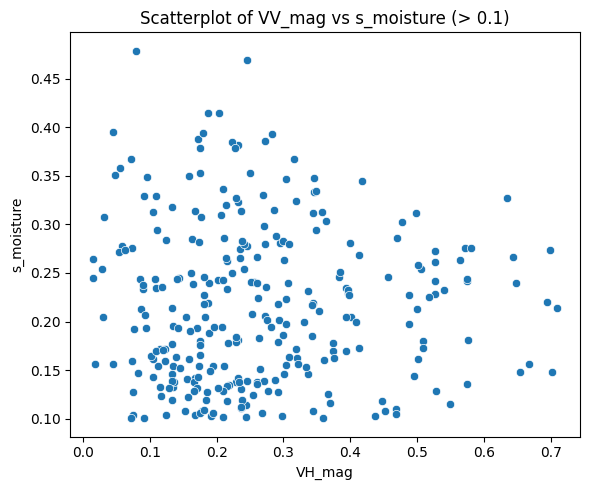

In [ ]:
data['VV_mag'] = np.sqrt(data['Real_VV']**2 + data['Imag_VV']**2)
data['VH_mag'] = np.sqrt(data['Real_VH']**2 + data['Imag_VH']**2)

data['VV_phase'] = np.arctan2(data['Imag_VV'], data['Real_VV'])
data['VH_phase'] = np.arctan2(data['Imag_VH'], data['Real_VH'])
selected_cols = ['VV_mag', 'VH_mag', 'VV_phase', 'VH_phase', 's_moisture', 's_roughness']
corr = data[selected_cols].corr()
print(corr)
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data where soil moisture is greater than 0.1
filtered_data = data[data['s_moisture'] > 0.1]

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x='VV_mag', y='s_moisture', data=filtered_data)
plt.title('Scatterplot of VV_mag vs s_moisture (> 0.1)')
plt.xlabel('VH_mag')
plt.ylabel('s_moisture')
plt.tight_layout()
plt.show()



#OLS method

In [ ]:
# generate fixed random seed values for all 3 models!
def gen_random_seeds(num) :
  random_seed_values = np.random.randint(1,1000,num)
  return random_seed_values

random_seed_values = gen_random_seeds(num_rand_seeds)


In [ ]:


def ols(seed_value) :
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size, random_state=seed_value)
  X_train = np.hstack([np.ones((X_train.shape[0],1)),X_train])
  X_test = np.hstack([np.ones((X_test.shape[0],1)),X_test])

  beta,_,_,_ = np.linalg.lstsq(X_train,y_train,rcond = None)
  y_pred = X_test @beta
  ols_mse_s_roughness = mean_squared_error(y_test[:,0],y_pred[:,0])
  ols_mse_s_moisture = mean_squared_error(y_test[:,1],y_pred[:,1])

  return ols_mse_s_roughness, ols_mse_s_moisture

def ols_training_seed_value() :
  ols_mse_roughness_values = []
  ols_mse_moisture_values = []
  #random_seed_values = gen_random_seeds(num_rand_seeds)
  for seed in random_seed_values :
    # print(seed)
    set_seed(int(seed))
    roughness, moisture = ols(seed) # calling of ols function
    ols_mse_roughness_values.append(roughness)
    ols_mse_moisture_values.append(moisture)

  return ols_mse_roughness_values, ols_mse_moisture_values
ols_roughness_values, ols_moisture_values = ols_training_seed_value()
def get_statistics(values) :
  mean = np.mean(values)
  std_dev = np.std(values)
  return mean,std_dev
ols_roughness_mean, ols_roughness_std = get_statistics(ols_roughness_values)
ols_moisture_mean, ols_moisture_std = get_statistics(ols_moisture_values)
print(f"Average Mean MSE value of Soil Roughness is {ols_roughness_mean} & Standard Deviation is {ols_roughness_std}")
print(f"Average Mean MSE value of Soil Moisture is {ols_moisture_mean} & Standard Deviation is {ols_moisture_std}")


Average Mean MSE value of Soil Roughness is 0.3189802317522946 & Standard Deviation is 0.032914979969180594
Average Mean MSE value of Soil Moisture is 0.010809076867991296 & Standard Deviation is 0.0009471410335475309


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Generate fixed random seed values
def gen_random_seeds(num):
    return np.random.randint(1, 1000, num)

random_seed_values = gen_random_seeds(num_rand_seeds)

In [ ]:


# --- OLS function ---
def ols(seed_value):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed_value)
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    beta, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
    y_pred = X_test @ beta

    ols_mse_s_roughness = mean_squared_error(y_test[:, 0], y_pred[:, 0])
    ols_mse_s_moisture = mean_squared_error(y_test[:, 1], y_pred[:, 1])

    return ols_mse_s_roughness, ols_mse_s_moisture, y_test, y_pred

# --- Collect MSEs across seeds ---
def ols_training_seed_value():
    ols_mse_roughness_values = []
    ols_mse_moisture_values = []

    for seed in random_seed_values:
        set_seed(int(seed))
        roughness, moisture, _, _ = ols(seed)  # ✅ Now unpacking all values correctly
        ols_mse_roughness_values.append(roughness)
        ols_mse_moisture_values.append(moisture)

    return ols_mse_roughness_values, ols_mse_moisture_values

# Run OLS across seeds and collect MSEs
ols_roughness_values, ols_moisture_values = ols_training_seed_value()

# --- Statistics ---
def get_statistics(values):
    return np.mean(values), np.std(values)

ols_roughness_mean, ols_roughness_std = get_statistics(ols_roughness_values)
ols_moisture_mean, ols_moisture_std = get_statistics(ols_moisture_values)

print(f"Average Mean MSE value of Soil Roughness is {ols_roughness_mean:.6f} & Standard Deviation is {ols_roughness_std:.6f}")
print(f"Average Mean MSE value of Soil Moisture is {ols_moisture_mean:.6f} & Standard Deviation is {ols_moisture_std:.6f}")



Average Mean MSE value of Soil Roughness is 0.311514 & Standard Deviation is 0.023506
Average Mean MSE value of Soil Moisture is 0.010617 & Standard Deviation is 0.001438


In [ ]:
# Pick a specific seed
fixed_seed = 41
set_seed(fixed_seed)

# Get predictions and ground truth
_, _, y_test, y_pred = ols(fixed_seed)


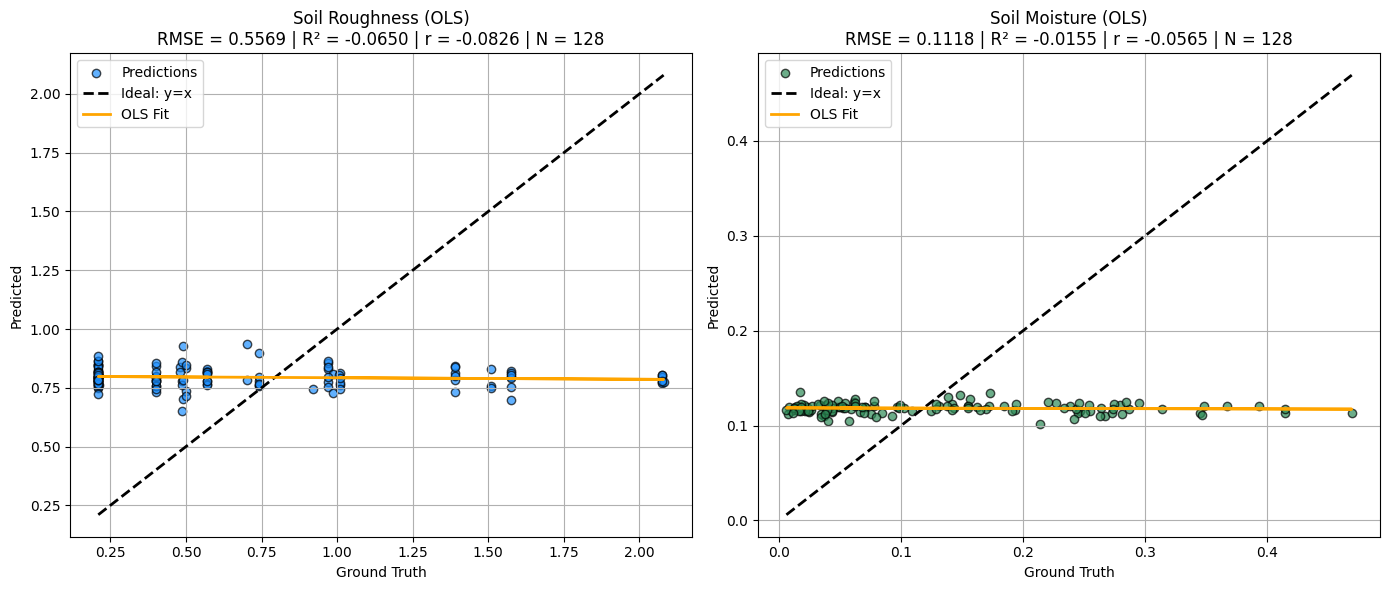

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_prediction_scatter(y_true, y_pred, label, color):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    n_samples = len(y_true)

    # Scatter plot
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k', color=color, label='Predictions')

    # Ideal line (y = x)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal: y=x')

    # Linear Regression Fit
    model = LinearRegression()
    model.fit(y_true.reshape(-1, 1), y_pred)
    y_fit = model.predict(y_true.reshape(-1, 1))
    plt.plot(y_true, y_fit, color='orange', linewidth=2, label='OLS Fit')

    # Plot details
    plt.xlabel("Ground Truth")
    plt.ylabel("Predicted")
    plt.title(f"{label}\nRMSE = {rmse:.4f} | R² = {r2:.4f} | r = {r:.4f} | N = {n_samples}")
    plt.grid(True)
    plt.legend()

# Create the figure
plt.figure(figsize=(14, 6))

# Soil Roughness subplot
plt.subplot(1, 2, 1)
plot_prediction_scatter(y_test[:, 0], y_pred[:, 0], label="Soil Roughness (OLS)", color='dodgerblue')

# Soil Moisture subplot
plt.subplot(1, 2, 2)
plot_prediction_scatter(y_test[:, 1], y_pred[:, 1], label="Soil Moisture (OLS)", color='seagreen')

plt.tight_layout()
plt.savefig("prediction_scatter_plots.png", dpi=300)  # or use .pdf/.svg
plt.show()

from google.colab import files
files.download("prediction_scatter_plots.png")

#modified for rmse_ols

In [ ]:
# @title
def ols(seed_value):
    # Split the data with a specific random seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed_value)

    # Add intercept (bias term)
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    # Perform ordinary least squares regression
    beta, _, _, _ = np.linalg.lstsq(X_train, y_train, rcond=None)
    y_pred = X_test @ beta

    # Compute MSE
    mse_roughness = mean_squared_error(y_test[:, 0], y_pred[:, 0])
    mse_moisture = mean_squared_error(y_test[:, 1], y_pred[:, 1])

    # Compute RMSE
    rmse_roughness = np.sqrt(mse_roughness)
    rmse_moisture = np.sqrt(mse_moisture)

    return mse_roughness, mse_moisture, rmse_roughness, rmse_moisture


def ols_training_seed_value():
    mse_roughness_values = []
    mse_moisture_values = []
    rmse_roughness_values = []
    rmse_moisture_values = []

    random_seed_values = gen_random_seeds(num_rand_seeds)

    for seed in random_seed_values:
        set_seed(int(seed))
        mse_r, mse_m, rmse_r, rmse_m = ols(seed)
        mse_roughness_values.append(mse_r)
        mse_moisture_values.append(mse_m)
        rmse_roughness_values.append(rmse_r)
        rmse_moisture_values.append(rmse_m)

    return mse_roughness_values, mse_moisture_values, rmse_roughness_values, rmse_moisture_values


# === Run and collect results ===
mse_roughness_values, mse_moisture_values, rmse_roughness_values, rmse_moisture_values = ols_training_seed_value()

# === Statistics function ===
def get_statistics(values):
    mean = np.mean(values)
    std_dev = np.std(values)
    return mean, std_dev

# === Get stats ===
mse_r_mean, mse_r_std = get_statistics(mse_roughness_values)
mse_m_mean, mse_m_std = get_statistics(mse_moisture_values)
rmse_r_mean, rmse_r_std = get_statistics(rmse_roughness_values)
rmse_m_mean, rmse_m_std = get_statistics(rmse_moisture_values)

# === Print ===
print(f"Mean MSE of Soil Roughness: {mse_r_mean:.4f}")
print(f"Standard Deviation of MSE (Roughness): {mse_r_std:.4f}")



print(f"Mean RMSE of Soil Roughness: {rmse_r_mean:.4f}")
print(f"Standard Deviation of RMSE (Roughness): {rmse_r_std:.4f}")

print(f"Mean MSE of Soil Moisture: {mse_m_mean:.4f}")
print(f"Standard Deviation of MSE (Moisture): {mse_m_std:.4f}")

print(f"Mean RMSE of Soil Moisture: {rmse_m_mean:.4f}")
print(f"Standard Deviation of RMSE (Moisture): {rmse_m_std:.4f}")



Mean MSE of Soil Roughness: 0.3045
Standard Deviation of MSE (Roughness): 0.0375
Mean RMSE of Soil Roughness: 0.5509
Standard Deviation of RMSE (Roughness): 0.0328
Mean MSE of Soil Moisture: 0.0103
Standard Deviation of MSE (Moisture): 0.0008
Mean RMSE of Soil Moisture: 0.1012
Standard Deviation of RMSE (Moisture): 0.0041


RVNN

In [ ]:
# @title
# Custom Data loader for Real Valued neural network
class SARRealDataset(Dataset) :
  def __init__(self,data) :
    self.data = data

    self.x = data[["Real_VV","Imag_VV","Real_VH","Imag_VH", "slope"]].values.astype(np.float32)
    self.y = data[["s_roughness","s_moisture"]].values.astype(np.float32)

  def __len__(self) :
    return len(self.x)


  def __getitem__(self,idx) :
    return torch.tensor(self.x[idx]), torch.tensor(self.y[idx])

# real_loader = DataLoader(real_dataset,batch_size=32,shuffle = True)

In [ ]:
# @title
#Model
class RealValuedNN(nn.Module) :
  def __init__(self) :
    super(RealValuedNN,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU(),
        nn.Linear(32,16),
        nn.ReLU(),
        nn.Linear(16,2)
    )

  def forward(self,x) :
    return self.model(x)

In [ ]:
# @title
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rvnn_model = RealValuedNN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rvnn_model.parameters(),lr = learning_rate)

In [ ]:
# @title
def rvnn_training_dataloader(seed_value) :
  train_idx,test_idx = train_test_split(np.arange(len(real_dataset)), test_size = test_size, random_state = seed_value)
  train_dataset = Subset(real_dataset,train_idx)
  test_dataset = Subset(real_dataset,test_idx)

  real_train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle = True)
  real_test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle = False)

  return real_train_loader, real_test_loader

In [ ]:
# @title
def rvnn_training(real_train_loader) :
  running_loss = 0
  for epoch in range(1,num_epochs+1) :
    rvnn_model.train()
    for inputs,targets in real_train_loader :
      inputs,targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = rvnn_model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
def rvnn_eval(real_test_loader) :
  rvnn_model.eval()
  moisture_test_loss = 0
  roughness_test_loss = 0
  with torch.no_grad() :
    for inputs,targets in real_test_loader :
      inputs,targets = inputs.to(device),targets.to(device)
      outputs = rvnn_model(inputs)
      roughness_loss = criterion(outputs[:,0], targets[:,0])
      moisture_loss = criterion(outputs[:,1], targets[:,1])
      moisture_test_loss+=moisture_loss.item()
      roughness_test_loss+=roughness_loss.item()

  moisture_test_loss = moisture_test_loss / len(real_test_loader)
  roughness_test_loss = roughness_test_loss / len(real_test_loader)

  return moisture_test_loss, roughness_test_loss

real_dataset = SARRealDataset(data)

def rv_nn_seed_values() :
  rv_nn_mse_roughness_values = []
  rv_nn_mse_moisture_values = []
  # random_seed_values = gen_random_seeds()
  for seed in random_seed_values :
    set_seed(int(seed))
    train_loader, test_loader = rvnn_training_dataloader(seed)
    rvnn_training(train_loader)
    rvnn_moistrue_mse, rvnn_roughness_mse = rvnn_eval(test_loader)
    rv_nn_mse_roughness_values.append(rvnn_roughness_mse)
    rv_nn_mse_moisture_values.append(rvnn_moistrue_mse)

  return rv_nn_mse_roughness_values, rv_nn_mse_moisture_values

In [ ]:
# @title
rvnn_roughness, rvnn_moisture = rv_nn_seed_values()
rvnn_roughness_mean, rvnn_roughness_std = get_statistics(rvnn_roughness)
rvnn_moisture_mean, rvnn_moisture_std = get_statistics(rvnn_moisture)
print(f"Average Mean MSE value of Soil Roughness is {rvnn_roughness_mean} & Standard Deviation is {rvnn_roughness_std}")
print(f"Average Mean MSE value of Soil Moisture is {rvnn_moisture_mean} & Standard Deviation is {rvnn_moisture_std}")

Average Mean MSE value of Soil Roughness is 0.21052277442067863 & Standard Deviation is 0.0797028921766365
Average Mean MSE value of Soil Moisture is 0.00971970586106181 & Standard Deviation is 0.0009612101469308397


rmse mod

In [ ]:
# @title
real_dataset = SARRealDataset(data)

def rv_nn_seed_values():
    rv_nn_mse_roughness_values = []
    rv_nn_mse_moisture_values = []
    rv_nn_rmse_roughness_values = []
    rv_nn_rmse_moisture_values = []

    for seed in random_seed_values:
        set_seed(int(seed))
        train_loader, test_loader = rvnn_training_dataloader(seed)
        rvnn_training(train_loader)

        rvnn_moisture_mse, rvnn_roughness_mse = rvnn_eval(test_loader)

        # Append MSE
        rv_nn_mse_roughness_values.append(rvnn_roughness_mse)
        rv_nn_mse_moisture_values.append(rvnn_moisture_mse)

        # Compute and append RMSE
        rv_nn_rmse_roughness_values.append(np.sqrt(rvnn_roughness_mse))
        rv_nn_rmse_moisture_values.append(np.sqrt(rvnn_moisture_mse))

    return (rv_nn_mse_roughness_values, rv_nn_mse_moisture_values,
            rv_nn_rmse_roughness_values, rv_nn_rmse_moisture_values)


In [ ]:
# @title
# Run the evaluation
(rvnn_roughness_mse, rvnn_moisture_mse,
 rvnn_roughness_rmse, rvnn_moisture_rmse) = rv_nn_seed_values()

# Compute statistics
mse_r_mean, mse_r_std = get_statistics(rvnn_roughness_mse)
mse_m_mean, mse_m_std = get_statistics(rvnn_moisture_mse)
rmse_r_mean, rmse_r_std = get_statistics(rvnn_roughness_rmse)
rmse_m_mean, rmse_m_std = get_statistics(rvnn_moisture_rmse)

# Print results
print(f"Mean MSE of Soil Roughness: {mse_r_mean:.4f}")
print(f"Standard Deviation of MSE (Roughness): {mse_r_std:.4f}")

print(f"Mean RMSE of Soil Roughness: {rmse_r_mean:.4f}")
print(f"Standard Deviation of RMSE (Roughness): {rmse_r_std:.4f}")

print(f"Mean MSE of Soil Moisture: {mse_m_mean:.4f}")
print(f"Standard Deviation of MSE (Moisture): {mse_m_std:.4f}")

print(f"Mean RMSE of Soil Moisture: {rmse_m_mean:.4f}")
print(f"Standard Deviation of RMSE (Moisture): {rmse_m_std:.4f}")


Mean MSE of Soil Roughness: 0.1847
Standard Deviation of MSE (Roughness): 0.0348
Mean RMSE of Soil Roughness: 0.4279
Standard Deviation of RMSE (Roughness): 0.0400
Mean MSE of Soil Moisture: 0.0099
Standard Deviation of MSE (Moisture): 0.0010
Mean RMSE of Soil Moisture: 0.0993
Standard Deviation of RMSE (Moisture): 0.0051


In [ ]:
# @title
# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
real_model = RealValuedNN().to(device)
real_param_count = count_parameters(real_model)
print(f"Number of parameters in Real-Valued NN: {real_param_count}")

Number of parameters in Real-Valued NN: 2962


#cvnn

In [ ]:
# @title
# Complex Custom Dataset
class SARComplexDataset(Dataset):
    def __init__(self, data):
        self.data = data
        vv = data['Real_VV'].values + 1j * data['Imag_VV'].values
        vh = data['Real_VH'].values + 1j * data['Imag_VH'].values
        self.x = np.stack((vv, vh), axis=1).astype(np.complex64)
        self.y = data[["s_roughness", "s_moisture"]].values.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        x_tensor = torch.tensor(np.stack([x.real, x.imag], axis=-1), dtype=torch.float32)   # Complex data
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_tensor, y_tensor
# Complex Linear Layer
class CLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CLinear, self).__init__()
        self.re = nn.Linear(in_features, out_features)
        self.im = nn.Linear(in_features, out_features)
        nn.init.xavier_uniform_(self.re.weight)
        nn.init.xavier_uniform_(self.im.weight)

    def forward(self, x):
        x_re = x[..., 0]    # Extracting Real part
        x_im = x[..., 1]    # Extracting Imag part
        out_re = self.re(x_re) - self.im(x_im)
        out_im = self.re(x_im) + self.im(x_re)
        return torch.stack([out_re, out_im], dim=-1)  # Combining Real and Imag to Complex
class ComplexFeedForward(nn.Module):
    def __init__(self):
          super(ComplexFeedForward, self).__init__()
          self.fc1 = CLinear(2, 28)
          self.relu1 = nn.ReLU()

          self.fc2 = CLinear(28, 28)
          self.relu2 = nn.ReLU()

          self.fc3 = CLinear(28, 18)
          self.relu3 = nn.ReLU()

         # self.output_layer = nn.Linear(18, 2)  # final output is real-valued
          self.output_layer = CLinear(18,2)



    def forward(self, x):
        x = self.fc1(x)
        # print('first', x.shape)
        x = self.relu1(x)  # real part for activation
        # print('2', x.shape)
        x = self.fc2(x)  # convert to complex
        x = self.relu2(x)
        # print('3', x.shape)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        # print('4', x.shape)
        # return x[..., 0]  # returns [batch_size, 2] Returning Real Part
        return x[..., 0]**2 + x[..., 1]**2 # returns [batch_size, 2] Returning Magnitude Square
def cvnn_training_dataloader(seed_value) :
  # Split
  train_idx, test_idx = train_test_split(np.arange(len(complex_dataset)), test_size=0.2, random_state=seed_value)
  complex_train_dataset = Subset(complex_dataset, train_idx)
  complex_test_dataset = Subset(complex_dataset, test_idx)

  # DataLoader
  complex_train_loader = DataLoader(complex_train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
  complex_test_loader = DataLoader(complex_test_dataset, batch_size=batch_size, shuffle=False)

  return complex_train_loader, complex_test_loader
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cvnn_model = ComplexFeedForward().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cvnn_model.parameters(), lr=learning_rate)

def cvnn_training(complex_train_loader) :
  for epoch in range(100):
    cvnn_model.train()
    epoch_loss = 0
    for inputs, targets in complex_train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = cvnn_model(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # if (epoch + 1) % 10 == 0:
    #     print(f"Epoch {epoch+1}/100, Loss: {epoch_loss / len(complex_train_loader):.4f}")
def cvnn_eval(test_loader) :
  cvnn_model.eval()
  moisture_test_loss = 0.0
  roughness_test_loss = 0.0
  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs = inputs.to(device)
          targets = targets.to(device)
          outputs = cvnn_model(inputs)
          roughness_loss = criterion(outputs[:,0], targets[:,0])
          moisture_loss = criterion(outputs[:,1], targets[:,1])
          moisture_test_loss+=moisture_loss.item()
          roughness_test_loss+=roughness_loss.item()

      moisture_test_loss = moisture_test_loss / len(test_loader)
      roughness_test_loss = roughness_test_loss / len(test_loader)

  return moisture_test_loss, roughness_test_loss

complex_dataset = SARComplexDataset(data)

def cv_valued_seed_values() :
  cv_nn_soil_roughness = []
  cv_nn_soil_moisture = []
  for seed in random_seed_values :
    set_seed(int(seed))
    train_loader, test_loader = cvnn_training_dataloader(seed)
    cvnn_training(train_loader)
    cvnn_moistrue_mse, cvnn_roughness_mse = cvnn_eval(test_loader)
    cv_nn_soil_roughness.append(cvnn_roughness_mse)
    cv_nn_soil_moisture.append(cvnn_moistrue_mse)

  return cv_nn_soil_roughness, cv_nn_soil_moisture

In [ ]:
# @title
cvnn1_roughness, cvnn1_moisture = cv_valued_seed_values()
cvnn1_roughness_mean, cvnn1_roughness_std = get_statistics(cvnn1_roughness)
cvnn1_moisture_mean, cvnn1_moisture_std = get_statistics(cvnn1_moisture)
print(f"Average Mean MSE value of Soil Roughness is {cvnn1_roughness_mean} & Standard Deviation is {cvnn1_roughness_std}")
print(f"Average Mean MSE value of Soil Moisture is {cvnn1_moisture_mean} & Standard Deviation is {cvnn1_moisture_std}")

Average Mean MSE value of Soil Roughness is 0.16536644850857557 & Standard Deviation is 0.026145399250550226
Average Mean MSE value of Soil Moisture is 0.009680971666239203 & Standard Deviation is 0.000733066942534787


#CVNN test

In [ ]:
# @title
# --- Complex Custom Dataset ---
class SARComplexDataset(Dataset):
    def __init__(self, data):
        self.data = data
        vv = data['Real_VV'].values + 1j * data['Imag_VV'].values
        vh = data['Real_VH'].values + 1j * data['Imag_VH'].values
        self.x = np.stack((vv, vh), axis=1).astype(np.complex64)
        self.y = data[["s_roughness", "s_moisture"]].values.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        x_tensor = torch.tensor(np.stack([x.real, x.imag], axis=-1), dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_tensor, y_tensor

# --- Complex Linear Layer ---
class CLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.re = nn.Linear(in_features, out_features)
        self.im = nn.Linear(in_features, out_features)
        nn.init.xavier_uniform_(self.re.weight)
        nn.init.xavier_uniform_(self.im.weight)

    def forward(self, x):
        x_re, x_im = x[..., 0], x[..., 1]
        out_re = self.re(x_re) - self.im(x_im)
        out_im = self.re(x_im) + self.im(x_re)
        return torch.stack([out_re, out_im], dim=-1)


class ComplexFeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = CLinear(2, 28)
        self.bn1_re = nn.BatchNorm1d(28)
        self.bn1_im = nn.BatchNorm1d(28)
        self.relu1 = nn.ReLU()

        self.fc2 = CLinear(28, 28)
        self.bn2_re = nn.BatchNorm1d(28)
        self.bn2_im = nn.BatchNorm1d(28)
        self.relu2 = nn.ReLU()

        self.fc3 = CLinear(28, 18)
        self.bn3_re = nn.BatchNorm1d(18)
        self.bn3_im = nn.BatchNorm1d(18)
        self.relu3 = nn.ReLU()

        self.output_layer = CLinear(18, 2)  # produces [batch, 2, 2]

        # Flattened size is 2×2 = 4, so use Linear(4→32→2)
        self.real_projection = nn.Sequential(
            nn.Linear(4, 28),
            nn.ReLU(),
            nn.Linear(28, 2)
        )

    def forward(self, x):
        x = self.fc1(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn1_re(re), self.bn1_im(im)
        x = torch.stack([re, im], dim=-1)
        x = self.relu1(x)    # correct: apply complex activation to both parts

        x = self.fc2(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn2_re(re), self.bn2_im(im)
        x = torch.stack([re, im], dim=-1)
        x = self.relu2(x)

        x = self.fc3(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn3_re(re), self.bn3_im(im)
        x = torch.stack([re, im], dim=-1)
        x = self.relu3(x)

        x = self.output_layer(x)      # [batch, 2, 2]
        x = x.view(x.size(0), -1)     # [batch, 4]
        return self.real_projection(x)  # [batch, 2]



# --- Training and Evaluation ---
def cvnn_training_dataloader(seed_value):
    train_idx, test_idx = train_test_split(np.arange(len(complex_dataset)), test_size=0.2, random_state=seed_value)
    train_dataset = Subset(complex_dataset, train_idx)
    test_dataset = Subset(complex_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
cvnn_model = ComplexFeedForward().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cvnn_model.parameters(), lr=learning_rate)

def cvnn_training(train_loader):
    for epoch in range(100):
        cvnn_model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = cvnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

def cvnn_eval(test_loader):
    cvnn_model.eval()
    roughness_loss, moisture_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cvnn_model(inputs)
            roughness_loss += criterion(outputs[:, 0], targets[:, 0]).item()
            moisture_loss += criterion(outputs[:, 1], targets[:, 1]).item()

    return moisture_loss / len(test_loader), roughness_loss / len(test_loader)

# --- Cross Validation ---
complex_dataset = SARComplexDataset(data)

def cv_valued_seed_values():
    cv_nn_soil_roughness, cv_nn_soil_moisture = [], []
    for seed in random_seed_values:
        set_seed(int(seed))
        train_loader, test_loader = cvnn_training_dataloader(seed)
        cvnn_training(train_loader)
        mse_moisture, mse_roughness = cvnn_eval(test_loader)
        cv_nn_soil_roughness.append(mse_roughness)
        cv_nn_soil_moisture.append(mse_moisture)
    return cv_nn_soil_roughness, cv_nn_soil_moisture


cpu


In [ ]:
# @title

cvnn2_roughness, cvnn2_moisture = cv_valued_seed_values()
cvnn2_roughness_mean, cvnn2_roughness_std = get_statistics(cvnn2_roughness)
cvnn2_moisture_mean, cvnn2_moisture_std = get_statistics(cvnn2_moisture)
print(f"Average Mean MSE value of Soil Roughness is {cvnn2_roughness_mean} & Standard Deviation is {cvnn2_roughness_std}")
print(f"Average Mean MSE value of Soil Moisture is {cvnn2_moisture_mean} & Standard Deviation is {cvnn2_moisture_std}")

Average Mean MSE value of Soil Roughness is 0.14856069893576204 & Standard Deviation is 0.02185086220927144
Average Mean MSE value of Soil Moisture is 0.00959923702175729 & Standard Deviation is 0.0007286438097148066


Leakycrelu

In [ ]:
# --- Complex Custom Dataset ---
class SARComplexDataset(Dataset):
    def __init__(self, data):
        self.data = data
        vv = data['Real_VV'].values + 1j * data['Imag_VV'].values
        vh = data['Real_VH'].values + 1j * data['Imag_VH'].values
        self.x = np.stack((vv, vh), axis=1).astype(np.complex64)
        self.y = data[["s_roughness", "s_moisture"]].values.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        x_tensor = torch.tensor(np.stack([x.real, x.imag], axis=-1), dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_tensor, y_tensor

# --- Complex Linear Layer ---
class CLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.re = nn.Linear(in_features, out_features)
        self.im = nn.Linear(in_features, out_features)
        nn.init.xavier_uniform_(self.re.weight)
        nn.init.xavier_uniform_(self.im.weight)

    def forward(self, x):
        x_re, x_im = x[..., 0], x[..., 1]
        out_re = self.re(x_re) - self.im(x_im)
        out_im = self.re(x_im) + self.im(x_re)
        return torch.stack([out_re, out_im], dim=-1)
class LeakyCReLU(nn.Module):
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.relu = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        real = self.relu(x[..., 0])
        imag = self.relu(x[..., 1])
        return torch.stack([real, imag], dim=-1)


class ComplexFeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = CLinear(2, 28)
        self.bn1_re = nn.BatchNorm1d(28)
        self.bn1_im = nn.BatchNorm1d(28)
        #self.relu1 = nn.ReLU()
        self.act1=LeakyCReLU()

        self.fc2 = CLinear(28, 28)
        self.bn2_re = nn.BatchNorm1d(28)
        self.bn2_im = nn.BatchNorm1d(28)
        #self.relu2 = nn.ReLU()
        self.act2=LeakyCReLU()
        self.fc3 = CLinear(28, 18)
        self.bn3_re = nn.BatchNorm1d(18)
        self.bn3_im = nn.BatchNorm1d(18)
        #self.relu3 = nn.ReLU()
        self.act3=LeakyCReLU()
        self.output_layer = CLinear(18, 2)


        self.real_projection = nn.Sequential(
            nn.Linear(4, 28),
            nn.ReLU(),
            nn.Linear(28, 2)
        )

    def forward(self, x):
        x = self.fc1(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn1_re(re), self.bn1_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu1(x)
        x=self.act1(x)
        x = self.fc2(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn2_re(re), self.bn2_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu2(x)
        x=self.act2(x)
        x = self.fc3(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn3_re(re), self.bn3_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu3(x)
        x=self.act3(x)
        x = self.output_layer(x)      # [batch, 2, 2]
        x = x.view(x.size(0), -1)     # [batch, 4]
        return self.real_projection(x)  # [batch, 2]



# --- Training and Evaluation ---
def cvnn_training_dataloader(seed_value):
    train_idx, test_idx = train_test_split(np.arange(len(complex_dataset)), test_size=0.2, random_state=seed_value)
    train_dataset = Subset(complex_dataset, train_idx)
    test_dataset = Subset(complex_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
cvnn_model = ComplexFeedForward().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cvnn_model.parameters(), lr=learning_rate)

def cvnn_training(train_loader):
    for epoch in range(100):
        cvnn_model.train()
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = cvnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

def cvnn_eval(test_loader):
    cvnn_model.eval()
    roughness_loss, moisture_loss = 0.0, 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cvnn_model(inputs)
            roughness_loss += criterion(outputs[:, 0], targets[:, 0]).item()
            moisture_loss += criterion(outputs[:, 1], targets[:, 1]).item()

    return moisture_loss / len(test_loader), roughness_loss / len(test_loader)

# --- Cross Validation ---
complex_dataset = SARComplexDataset(data)

def cv_valued_seed_values():
    cv_nn_soil_roughness, cv_nn_soil_moisture = [], []
    for seed in random_seed_values:
        set_seed(int(seed))
        train_loader, test_loader = cvnn_training_dataloader(seed)
        cvnn_training(train_loader)
        mse_moisture, mse_roughness = cvnn_eval(test_loader)
        cv_nn_soil_roughness.append(mse_roughness)
        cv_nn_soil_moisture.append(mse_moisture)
    return cv_nn_soil_roughness, cv_nn_soil_moisture


cpu


In [ ]:
cvnn_roughness, cvnn_moisture = cv_valued_seed_values()
cvnn_roughness_mean, cvnn_roughness_std = get_statistics(cvnn_roughness)
cvnn_moisture_mean, cvnn_moisture_std = get_statistics(cvnn_moisture)
print(f"Average Mean MSE value of Soil Roughness is {cvnn_roughness_mean} & Standard Deviation is {cvnn_roughness_std}")
print(f"Average Mean MSE value of Soil Moisture is {cvnn_moisture_mean} & Standard Deviation is {cvnn_moisture_std}")

NameError: name 'get_statistics' is not defined

ch

cpu
Using device: cpu


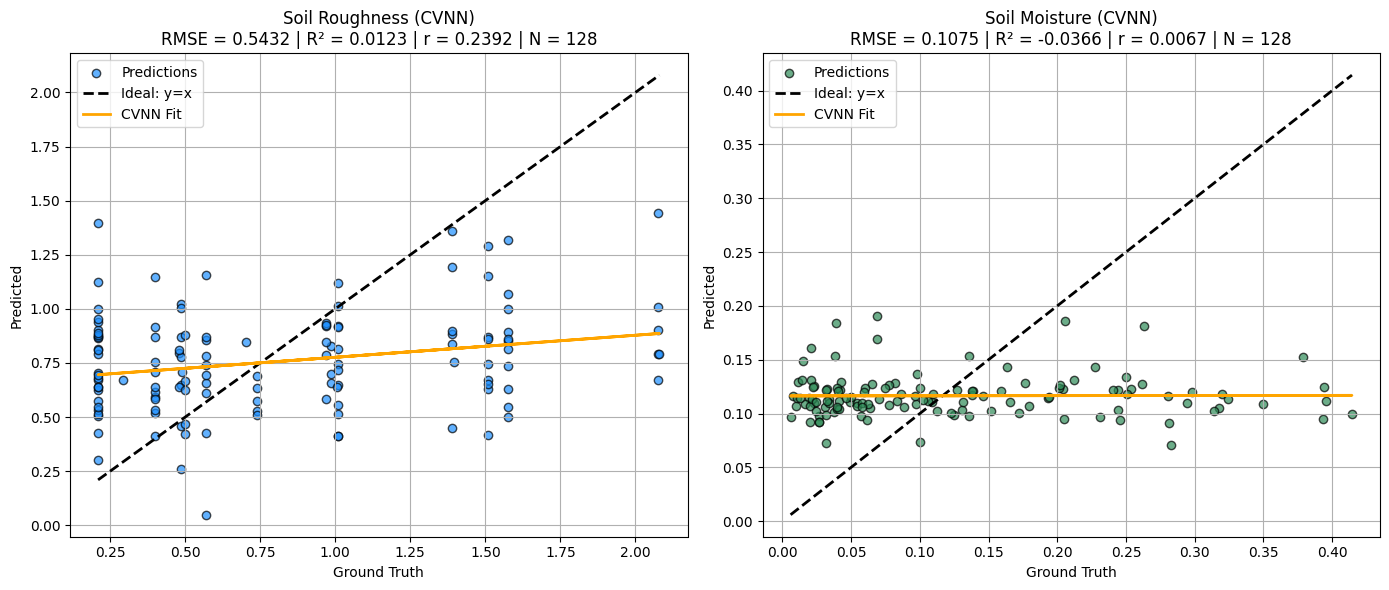

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Complex Custom Dataset ---
class SARComplexDataset(Dataset):
    def __init__(self, data):
        self.data = data
        vv = data['Real_VV'].values + 1j * data['Imag_VV'].values
        vh = data['Real_VH'].values + 1j * data['Imag_VH'].values
        self.x = np.stack((vv, vh), axis=1).astype(np.complex64)
        self.y = data[["s_roughness", "s_moisture"]].values.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        x_tensor = torch.tensor(np.stack([x.real, x.imag], axis=-1), dtype=torch.float32)
        y_tensor = torch.tensor(self.y[idx], dtype=torch.float32)
        return x_tensor, y_tensor

# --- Complex Linear Layer ---
class CLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.re = nn.Linear(in_features, out_features)
        self.im = nn.Linear(in_features, out_features)
        nn.init.xavier_uniform_(self.re.weight)
        nn.init.xavier_uniform_(self.im.weight)

    def forward(self, x):
        x_re, x_im = x[..., 0], x[..., 1]
        out_re = self.re(x_re) - self.im(x_im)
        out_im = self.re(x_im) + self.im(x_re)
        return torch.stack([out_re, out_im], dim=-1)
class LeakyCReLU(nn.Module):
    def __init__(self, negative_slope=0.1):
        super().__init__()
        self.relu = nn.LeakyReLU(negative_slope)

    def forward(self, x):
        real = self.relu(x[..., 0])
        imag = self.relu(x[..., 1])
        return torch.stack([real, imag], dim=-1)


class ComplexFeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = CLinear(2, 28)
        self.bn1_re = nn.BatchNorm1d(28)
        self.bn1_im = nn.BatchNorm1d(28)
        #self.relu1 = nn.ReLU()
        self.act1=LeakyCReLU()

        self.fc2 = CLinear(28, 28)
        self.bn2_re = nn.BatchNorm1d(28)
        self.bn2_im = nn.BatchNorm1d(28)
        #self.relu2 = nn.ReLU()
        self.act2=LeakyCReLU()
        self.fc3 = CLinear(28, 18)
        self.bn3_re = nn.BatchNorm1d(18)
        self.bn3_im = nn.BatchNorm1d(18)
        #self.relu3 = nn.ReLU()
        self.act3=LeakyCReLU()
        self.output_layer = CLinear(18, 2)


        self.real_projection = nn.Sequential(
            nn.Linear(4, 28),
            nn.ReLU(),
            nn.Linear(28, 2)
        )

    def forward(self, x):
        x = self.fc1(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn1_re(re), self.bn1_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu1(x)
        x=self.act1(x)
        x = self.fc2(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn2_re(re), self.bn2_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu2(x)
        x=self.act2(x)
        x = self.fc3(x)
        re, im = x[..., 0], x[..., 1]
        re, im = self.bn3_re(re), self.bn3_im(im)
        x = torch.stack([re, im], dim=-1)
        #x = self.relu3(x)
        x=self.act3(x)
        x = self.output_layer(x)      # [batch, 2, 2]
        x = x.view(x.size(0), -1)     # [batch, 4]
        return self.real_projection(x)  # [batch, 2]



# --- Training and Evaluation ---
def cvnn_training_dataloader(seed_value):
    train_idx, test_idx = train_test_split(np.arange(len(complex_dataset)), test_size=0.2, random_state=seed_value)
    train_dataset = Subset(complex_dataset, train_idx)
    test_dataset = Subset(complex_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
cvnn_model = ComplexFeedForward().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cvnn_model.parameters(), lr=learning_rate)

def cvnn_training(train_loader, model, optimizer, criterion):
    model.train()
    for epoch in range(100):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

# --- Evaluate + Plot ---
def plot_prediction_scatter(y_true, y_pred, label, color):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    n = len(y_true)

    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k', color=color, label='Predictions')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal: y=x')

    model = LinearRegression().fit(y_true.reshape(-1, 1), y_pred)
    y_fit = model.predict(y_true.reshape(-1, 1))
    plt.plot(y_true, y_fit, color='orange', linewidth=2, label='CVNN Fit')

    plt.xlabel("Ground Truth")
    plt.ylabel("Predicted")
    plt.title(f"{label}\nRMSE = {rmse:.4f} | R² = {r2:.4f} | r = {r:.4f} | N = {n}")
    plt.grid(True)
    plt.legend()

# --- Main Execution for One Seed ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

seed_for_plot = 20
set_seed(seed_for_plot)
train_loader, test_loader = cvnn_training_dataloader(seed_for_plot)

cvnn_model = ComplexFeedForward().to(device)
optimizer = torch.optim.Adam(cvnn_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

cvnn_training(train_loader, cvnn_model, optimizer, criterion)

# --- Collect Predictions ---
cvnn_model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = cvnn_model(inputs).cpu().numpy()
        targets = targets.cpu().numpy()
        y_pred_all.append(outputs)
        y_true_all.append(targets)

y_pred_all = np.vstack(y_pred_all)
y_true_all = np.vstack(y_true_all)

# --- Plot and Save ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_prediction_scatter(y_true_all[:, 0], y_pred_all[:, 0], "Soil Roughness (CVNN)", 'dodgerblue')

plt.subplot(1, 2, 2)
plot_prediction_scatter(y_true_all[:, 1], y_pred_all[:, 1], "Soil Moisture (CVNN)", 'seagreen')

plt.tight_layout()
plt.savefig("cvnn_scatter_plot.png", dpi=300)
plt.show()
from google.colab import files
files.download("cvnn_scatter_plot.png")

figure

In [ ]:
boxplot

/tmp/ipython-input-17-105730453.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(mse_roughness_list, labels=labels, patch_artist=True)
/tmp/ipython-input-17-105730453.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(mse_moisture_list, labels=labels, patch_artist=True)


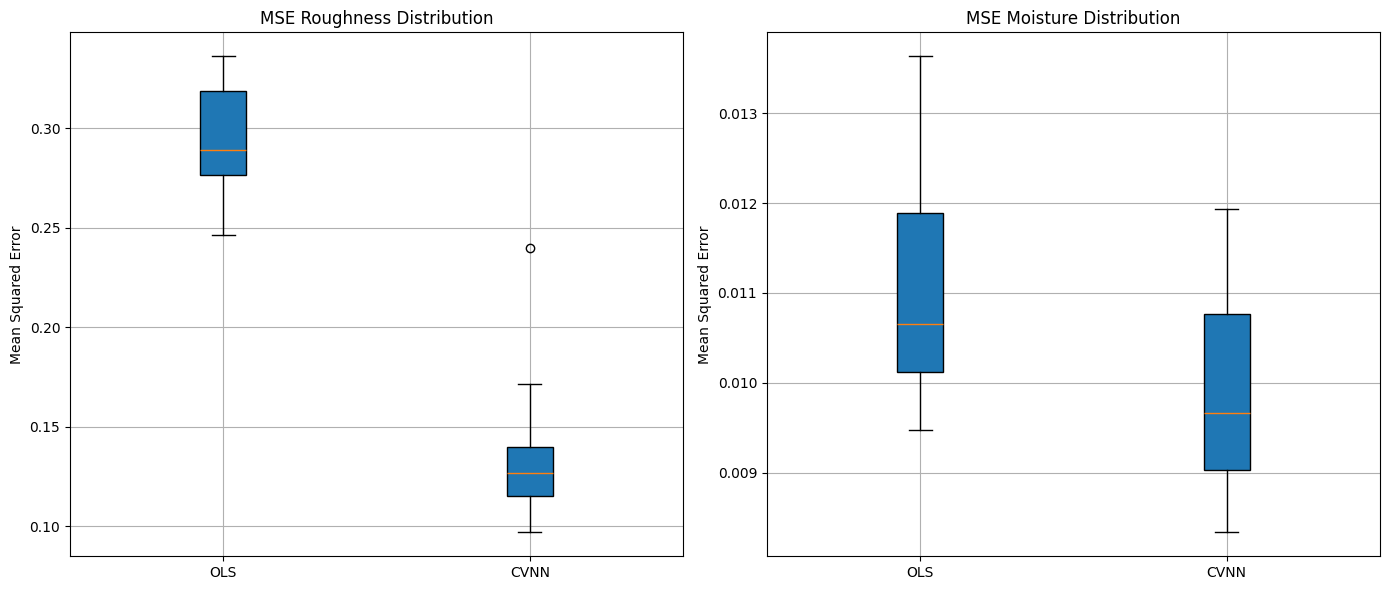

In [ ]:
# @title
mse_roughness_list = [ols_roughness_values, cvnn_roughness]
mse_moisture_list = [ols_moisture_values, cvnn_moisture]
labels = ['OLS', 'CVNN']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Roughness plot
axs[0].boxplot(mse_roughness_list, labels=labels, patch_artist=True)
axs[0].set_title("MSE Roughness Distribution")
axs[0].set_ylabel("Mean Squared Error")
axs[0].grid(True)

# Moisture plot
axs[1].boxplot(mse_moisture_list, labels=labels, patch_artist=True)
axs[1].set_title("MSE Moisture Distribution")
axs[1].set_ylabel("Mean Squared Error")
axs[1].grid(True)

plt.tight_layout()
plt.show()

/tmp/ipython-input-22-2743064048.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot1 = axs[0].boxplot(
/tmp/ipython-input-22-2743064048.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot2 = axs[1].boxplot(


Mean MSE - Roughness
OLS: 0.294747
CVNN: 0.133014

Mean MSE - Moisture
OLS: 0.011010
CVNN: 0.009936


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

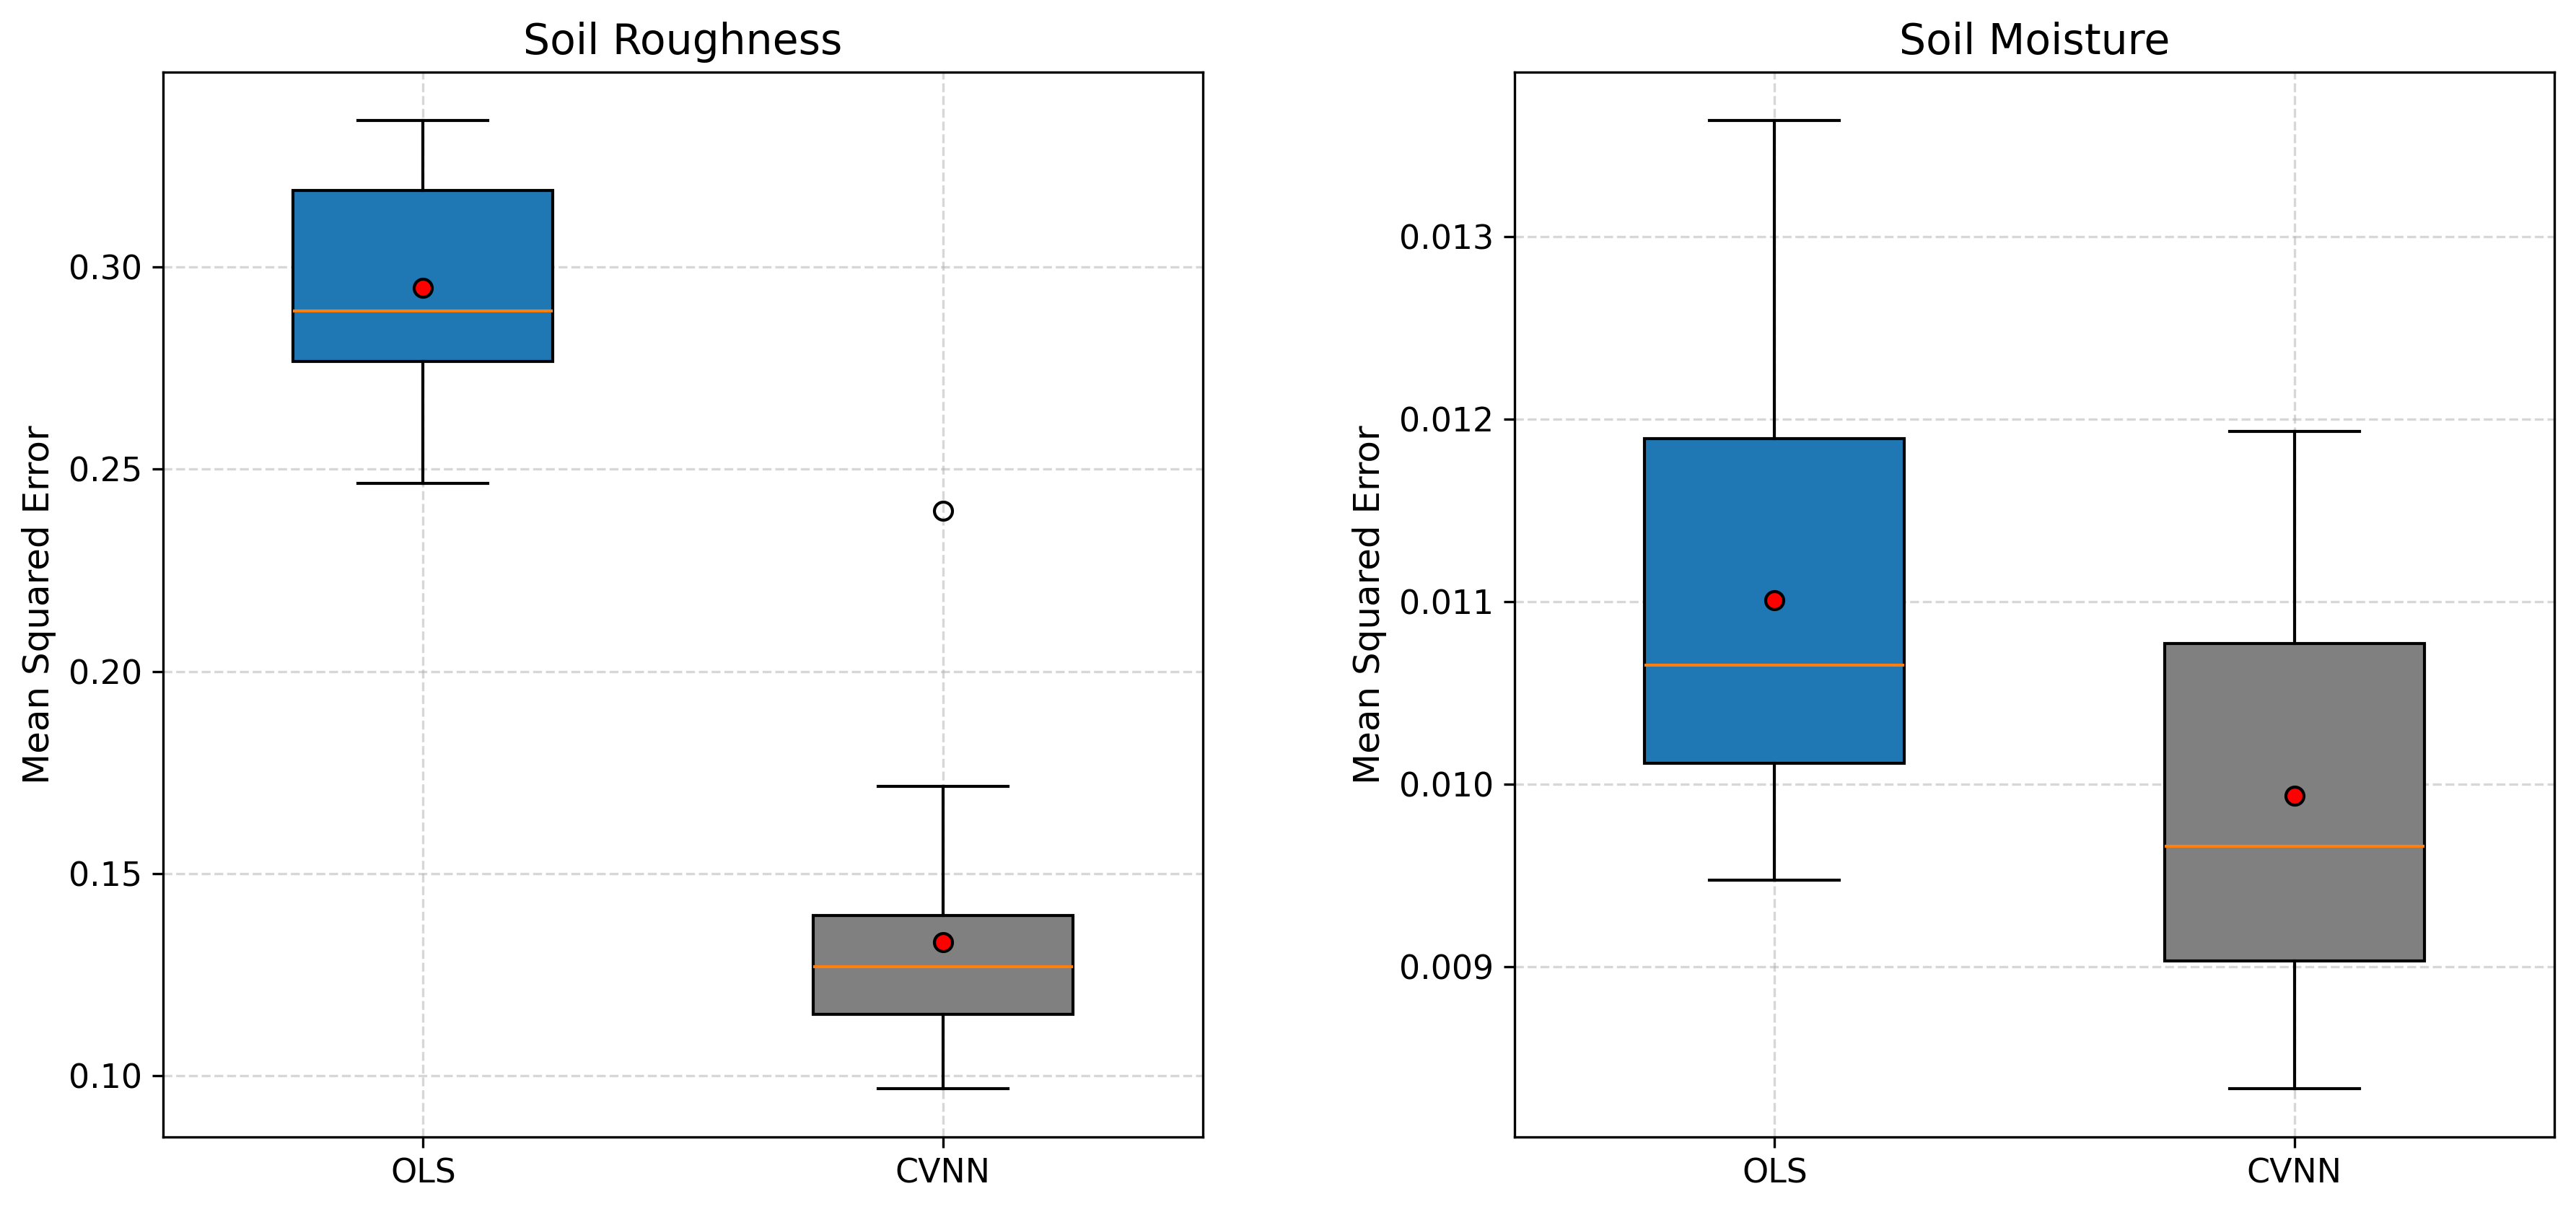

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mse_roughness_list = [ols_roughness_values, cvnn_roughness]
mse_moisture_list = [ols_moisture_values, cvnn_moisture]
labels = ['OLS', 'CVNN']

# Colors for each box (optional but looks cleaner)
colors = ['#1f77b4', 'gray']  # blue, orange

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

# Mean marker style
meanprops = dict(marker='o', markerfacecolor='red', markeredgecolor='black', markersize=6)
medianprops = dict(color='black', linewidth=2)  # <-- Black median line


# --- Plot 1: Roughness ---
bplot1 = axs[0].boxplot(
    mse_roughness_list, labels=labels, patch_artist=True,
    showmeans=True, meanprops=meanprops, widths=0.5
)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

axs[0].set_title("Soil Roughness", fontsize=14)
axs[0].set_ylabel("Mean Squared Error", fontsize=12)
axs[0].tick_params(axis='both', labelsize=11)
axs[0].grid(True, linestyle='--', alpha=0.5)

# --- Plot 2: Moisture ---
bplot2 = axs[1].boxplot(
    mse_moisture_list, labels=labels, patch_artist=True,
    showmeans=True, meanprops=meanprops, widths=0.5
)
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

axs[1].set_title("Soil Moisture", fontsize=14)
axs[1].set_ylabel("Mean Squared Error", fontsize=12)
axs[1].tick_params(axis='both', labelsize=11)
axs[1].grid(True, linestyle='--', alpha=0.5)

# --- Layout and Legend ---
# Custom legend for mean
#fig.legend(['Mean'], loc='upper center', ncol=1, frameon=False, fontsize=11, markerscale=1.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(wspace=0.3)
import numpy as np

# Compute and print mean values
print("Mean MSE - Roughness")
for label, values in zip(labels, mse_roughness_list):
    print(f"{label}: {np.mean(values):.6f}")

print("\nMean MSE - Moisture")
for label, values in zip(labels, mse_moisture_list):
    print(f"{label}: {np.mean(values):.6f}")
plt.savefig("mse_boxplot.png", dpi=300, bbox_inches='tight')
from google.colab import files
files.download("mse_boxplot.png")
plt.show()
